La modélisation du langage consiste à apprendre la distribution de probabilité du mot suivant étant donné un historique. Ici, nous allons créer un modèle de langage sur des caractères pour apprendre à générer des titres de films de science fiction.

Le jeu de données provient d'IMDB qui permet d'accèder à de nombreuses infos sur les films, et en plus donne ces données en téléchargement libre (http://www.imdb.com/interfaces/).

Le fichier movies-sf.txt contient des noms de films suivis de leur année de sortie entre parenthèses extraits à partir de la base de données IMDB à l'aide de la commande awk en commentaire.

In [14]:
! pip install torch

In [0]:
%matplotlib inline

In [16]:
%%bash
#wget https://datasets.imdbws.com/title.basics.tsv.gz
#zcat title.basics.tsv.gz | awk -F"\t" '$2=="movie" && $5==0 && /Sci-Fi/ && $6!="\\N"{print $3" ("$6")"}' | iconv -f utf8 -t ascii//TRANSLIT | sort -u | shuf > movies-sf.txt
[ -f movies-sf.txt ] || wget -q http://pageperso.lif.univ-mrs.fr/~benoit.favre/files/movies-sf.txt
head movies-sf.txt

Passengers (2016)
Stealth (2005)
Utterance (1997)
Homunculus, 6. Teil - Das Ende des Homunculus (1917)
Framework (2009)
Redshift (2013)
Jupiter 2023 (2018)
Fuerza maldita (1995)
Horrors of War (2006)
500 MPH Storm (2013)


Nous allons charger les titres caractère par caractère et encoder ces derniers sous forme d'entiers. Le vocabulaire est produit avec un `defaultdict` qui donne un nouvel identifiant à chaque nouveau caractère rencontré. Nous ajoutons deux caractères spéciaux : 
- le symbole `<eos>` pour le padding
- le symbole `<start>` qui indique le début de la séquence

Le problème va être posé comme prédire le caractère suivant étant donné le caractère courant et un état caché, et nous avons donc besoin d'un symbole `<start>` pour prédire le premier caractère. La fin d'un texte sera prédite par la première occurrence d'un symbole `<eos>`. 

Nous pouvons tout de suite créer un vocabulaire inversé pour vérifier le contenu des données chargées.

In [17]:
import collections
vocab = collections.defaultdict(lambda: len(vocab))
vocab['<eos>'] = 0
vocab['<start>'] = 1

int_texts = []
with open('movies-sf.txt', 'r') as fp:
    for line in fp:
        int_texts.append([vocab['<start>']] + [vocab[char] for char in line.strip()])

rev_vocab = {y: x for x, y in vocab.items()}

print(rev_vocab)
print(len(int_texts))

print(int_texts[42])
print(''.join([rev_vocab[x] for x in int_texts[42]]))

{0: '<eos>', 1: '<start>', 2: 'P', 3: 'a', 4: 's', 5: 'e', 6: 'n', 7: 'g', 8: 'r', 9: ' ', 10: '(', 11: '2', 12: '0', 13: '1', 14: '6', 15: ')', 16: 'S', 17: 't', 18: 'l', 19: 'h', 20: '5', 21: 'U', 22: 'c', 23: '9', 24: '7', 25: 'H', 26: 'o', 27: 'm', 28: 'u', 29: ',', 30: '.', 31: 'T', 32: 'i', 33: '-', 34: 'D', 35: 'E', 36: 'd', 37: 'F', 38: 'w', 39: 'k', 40: 'R', 41: 'f', 42: '3', 43: 'J', 44: 'p', 45: '8', 46: 'z', 47: 'W', 48: 'M', 49: 'v', 50: 'A', 51: 'N', 52: '4', 53: 'B', 54: 'V', 55: 'I', 56: 'L', 57: 'G', 58: 'b', 59: 'C', 60: ':', 61: 'X', 62: 'x', 63: 'y', 64: 'O', 65: 'Z', 66: 'j', 67: 'q', 68: 'Y', 69: "'", 70: '?', 71: 'Q', 72: '/', 73: '&', 74: 'K', 75: '!', 76: '=', 77: '_', 78: '+', 79: ';', 80: '@', 81: '#', 82: '%', 83: '$'}
7205
[1, 31, 19, 5, 9, 2, 32, 6, 39, 9, 59, 19, 32, 67, 28, 32, 17, 3, 4, 9, 10, 13, 23, 45, 24, 15]
<start>The Pink Chiquitas (1987)


Afin de bien choisir la longueur maximale sur laquelle le modèle va être entrainé, affichons l'histograme des longueurs de séquences.

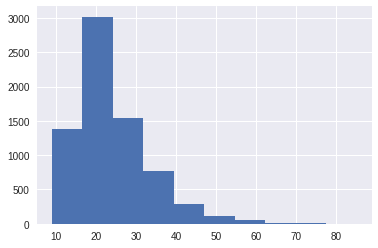

In [18]:
from matplotlib import pyplot as plt

plt.hist([len(text) for text in int_texts])
plt.show()

Il semble qu'une longeur maximale de 40 permettra de traiter une bonne partie des titres.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

max_len = 40
batch_size = 8
embed_size = 16
hidden_size = 64

Le problème est similaire à un problème de tagging sauf que l'étiquette à prédire est le caractère suivant, donc nous devons agencer les tenseurs de manière à ce que $y_{t} = x_{t+1}$. Il faut calculer la longueur après coupure des séquences les plus longues, puis créer un tenseur à partir du texte pour $x$ et un tenseur à partir du texte décalé de 1 vers la gauche pour $y$.

N'oublions pas de vérifier que les données ont la bonne forme.

In [20]:
X = torch.zeros(len(int_texts), max_len).long()
Y = torch.zeros(len(int_texts), max_len).long()

for i, text in enumerate(int_texts):
    length = min(max_len, len(text) - 1) + 1
    X[i,:length - 1] = torch.LongTensor(text[:length - 1])
    Y[i,:length - 1] = torch.LongTensor(text[1:length])

print(X[42].tolist())
print(Y[42].tolist())
print([rev_vocab[y] for y in Y[42].tolist()])

[1, 31, 19, 5, 9, 2, 32, 6, 39, 9, 59, 19, 32, 67, 28, 32, 17, 3, 4, 9, 10, 13, 23, 45, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[31, 19, 5, 9, 2, 32, 6, 39, 9, 59, 19, 32, 67, 28, 32, 17, 3, 4, 9, 10, 13, 23, 45, 24, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['T', 'h', 'e', ' ', 'P', 'i', 'n', 'k', ' ', 'C', 'h', 'i', 'q', 'u', 'i', 't', 'a', 's', ' ', '(', '1', '9', '8', '7', ')', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


Nous découpons les données en un ensemble d'entraînement et un ensemble de validation, puis les outils pytorch pour créer des batches mélangés sont utilisés comme d'habitude.

In [0]:
X_train = X[:6500]
Y_train = Y[:6500]
X_valid = X[6500:]
Y_valid = Y[6500:]

from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

Le modèle ressemble beaucoup à un taggeur. La première différence est qu'il ne peut pas être bidirectionnel, puisque la causalité est importante (on va générer des textes caractère par caratère en partant de `<start>`). La seconde différence est que la fonction `forward` va prendre un nouveau paramètre optionnel, l'état caché au temps précédent, et renvoyer non seulmenent les scores générés par le modèle, mais le nouvel état caché après avoir vu la séquence représentée dans `x`. Ceci sera nécessire pour la génération caractère par caractère. 

In [51]:
class LM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size, padding_idx=vocab['<eos>'])
        self.rnn = nn.GRU(embed_size, hidden_size,  bias=False, num_layers=1, dropout=0.3, batch_first=True)
        self.decision = nn.Linear(hidden_size, len(vocab))
    
    def forward(self, x, h_0=None):
        embed = self.embed(x)
        output, h_n = self.rnn(embed, h_0)
        return self.decision(output), h_n

model = LM()
model

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LM(
  (embed): Embedding(84, 16, padding_idx=0)
  (rnn): GRU(16, 64, bias=False, batch_first=True, dropout=0.3)
  (decision): Linear(in_features=64, out_features=84, bias=True)
)

On peut tester le modèle sur un batch. Il n'est pas obligatoire de passer un état caché initial (le module GRU s'en occupe si l'état caché passé est à `None`), mais on doit récupérer le nouvel état caché même si nous n'allons pas l'utiliser.

Remarquons que les sorties sont de taille `(batch_size, sequence_length, num_labels)` et l'état caché `(num_layers, batch_size, hidden_size)`.

In [23]:
output, hidden = model(Variable(X[:2]))
print(output.size(), hidden.size())

torch.Size([2, 40, 84]) torch.Size([1, 2, 64])


Il n'y a très peu de différences avec l'évaluation des performances pour un taggeur. Il faut penser que le modèle renvoie maintenant deux résultats (les scores et l'état caché) et donc mettre l'état caché dans une variable qui ne sert à rien.

À la place du taux de corrects, nous allons calculer la perplexité du modèle sur les données.

$
PP(x) = P(x)^{-\frac{1}{N}} = \left[\prod_i P(x_i)\right]^{-\frac{1}{N}}
$

où $x$ est une séquence de mots, $P(x)=\prod_i P(x_i)$ est la probabilité donnée par le modèle à cette séquence, et $N$ est sa longueur. On peut réécrire ce calcul en domaine log :

$
PP(x) = exp\left(-\frac{1}{N}\sum_i \log P(x_i)\right)
$

Il se trouve que la fonction de loss renvoie $-\frac{1}{N}\log P(x_i)$, donc il suffit de calculer l'exponentielle du loss moyen pour obtenir la perplexité. Cette perplexité n'est pas masquée pour éliminer le padding, donc elle est influencée par ce dernier (on ne pourrait pas profiter de la fonction de loss si l'on souhaitait ignorer le padding).

In [24]:
import math

def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = 0
    for x, y in loader:
        y_scores, _ = model(Variable(x, volatile=True))
        loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), Variable(y.view(y.size(0) * y.size(1)), volatile=True))
        total_loss += loss.data
        num += len(y)
    return total_loss / num, math.exp(total_loss / num)

perf(model, valid_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


(tensor(0.5639), 1.7575659270313564)

L'apprentissage est le même que pour le taggeur sauf qu'il faut prendre en compte l'état caché.

In [52]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores, _ = model(Variable(x))
            loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), Variable(y.view(y.size(0) * y.size(1))))
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            num += len(y)
        print(epoch, total_loss / num, *perf(model, valid_loader))

fit(model, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


0 tensor(0.1960) tensor(0.1524) 1.1646601669435173
1 tensor(0.1463) tensor(0.1423) 1.1529561920424551
2 tensor(0.1393) tensor(0.1377) 1.147577896771369
3 tensor(0.1353) tensor(0.1348) 1.1442955228140739
4 tensor(0.1324) tensor(0.1327) 1.1419126963667787
5 tensor(0.1301) tensor(0.1311) 1.1400731864241018
6 tensor(0.1283) tensor(0.1301) 1.1389381951866795
7 tensor(0.1268) tensor(0.1291) 1.1378011972834516
8 tensor(0.1255) tensor(0.1281) 1.136618316543369
9 tensor(0.1243) tensor(0.1271) 1.1355317561364742


Écrivons maintenant une fonction de génération. Cette dernère créé un tenseur $x$ contenant le symbole `<start>`, et un état caché à 0. Puis, elle repète l'application du modèle sur $x$ et l'état caché, pour générer un nouvel état caché et un vecteur de $y_{\mathrm{scores}}$ sur les caractères. On peut alors sélectionner la composante de plus haut score, l'afficher et mettre à jour $x$ pour qu'il contienne le symbole généré. Il suffit ensuite de boucler jusqu'à la génération de `<eos>`.

Le modèle génère toujours la même séquence de caractères, la séquence la plus probable étant donné le corpus d'apprentissage.

In [57]:
#import torch.nn.functional as F
def generate_most_probable(model):
    x = Variable(torch.zeros((1, 1)).long(), volatile=True)
    x[0, 0] = vocab['<start>']
    # size for hidden: (batch, num_layers * num_directions, hidden_size)
    hidden = Variable(torch.zeros(1, 1, hidden_size), volatile=True)
    for i in range(200):
        y_scores, hidden = model(x, hidden)
        y_pred = torch.max(y_scores, 2)[1]
        selected = int(y_pred.data[0, 0].numpy())
        if selected == vocab['<eos>']:
            break
        print(rev_vocab[selected], end='')
        x[0, 0] = selected
    print()

generate_most_probable(model)

The Man (2017)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Exercice
---------

Plutôt que de sélectionner le caractère ayant la plus grande probabilité, on peut tirer aléatoirement un caractère dans la distribution de probabilité après softmax. Utilisez `F.softmax` et `torch.multinomial` pour tirer aléatoirement un élément $s \sim softmax(y_{\textrm{scores}})$ dans la distribution des scores, et l'utiliser comme élément sélectionné à la place de celui issu du $max$.

On peut diviser les scores par une température $\theta$ avant de faire le softmax pour tasser la distriution. Une valeur de $\theta<1$ poussera le modèle à prendre moins de risque et générer des caractères plus probables, alors que $\theta>1$ lui fera prendre plus de risques et générer des séquences moins probables. En général, $\theta=0.7$ donne des résultas satisfaisants.

Générez 100 séquences avec cette méthode.

Pour aller plus loin
-----------------------

- Implementez Beam Search pour decoder les sequences en sortie. Ceci pour les cas avec et sans temperature